Philippe Joly
2024-07-14

# Football Field Homography

This notebook implements a translation from a camera shot of a football field to a bird's view homography mapping. This is done by taking various landmarks identified on the field and by interpolationg their position on the map using known field dimensions.

## Loading Image and Features

In [96]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

In [97]:
test_imgs = [
    "./test_images/1.jpg",
    "./test_images/2.jpg",
    "./test_images/3.png",
    "./test_images/4.png",
    "./test_images/5.png"
]

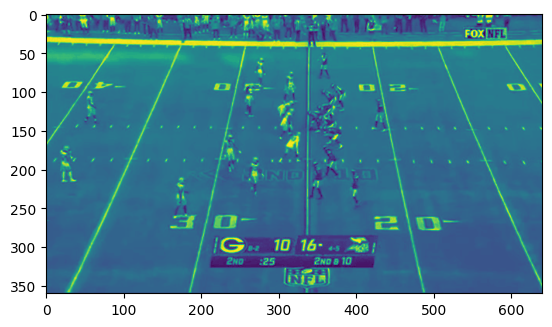

In [98]:
img_og = Image.open(test_imgs[3])
img = img_og.convert('L')
plt.imshow(img)

In [99]:
# pass img through trained model to detect field features
# lines, hashmarks, and yalrd line numbers

# lbls = model(img)

# constructed example
lbls = {
     "boxes": [
        {
            "label": "hash",
            "x": 443,
            "y": 149.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "hash",
            "x": 337.5,
            "y": 187,
            "width": 17,
            "height": 8
        },
        {
            "label": "hash",
            "x": 567,
            "y": 189.5,
            "width": 18,
            "height": 9
        },
        {
            "label": "hash",
            "x": 233,
            "y": 147.5,
            "width": 16,
            "height": 9
        },
        {
            "label": "edge",
            "x": 592.5,
            "y": 40.5,
            "width": 23,
            "height": 11
        },
        {
            "label": "hash",
            "x": 549.5,
            "y": 149.5,
            "width": 17,
            "height": 7
        },
        {
            "label": "hash",
            "x": 224,
            "y": 187.5,
            "width": 16,
            "height": 9
        },
        {
            "label": "hash",
            "x": 16,
            "y": 146,
            "width": 18,
            "height": 6
        },
        {
            "label": "hash",
            "x": 126,
            "y": 146.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "edge",
            "x": 174,
            "y": 40,
            "width": 22,
            "height": 12
        },
        {
            "label": "hash",
            "x": 450,
            "y": 188.5,
            "width": 18,
            "height": 7
        },
        {
            "label": "hash",
            "x": 109,
            "y": 187,
            "width": 18,
            "height": 8
        },
        {
            "label": "edge",
            "x": 257.5,
            "y": 42,
            "width": 19,
            "height": 12
        },
        {
            "label": "edge",
            "x": 421,
            "y": 42.5,
            "width": 18,
            "height": 13
        },
        {
            "label": "edge",
            "x": 505,
            "y": 41.5,
            "width": 22,
            "height": 13
        },
        {
            "label": "edge",
            "x": 87.5,
            "y": 38.5,
            "width": 21,
            "height": 13
        },
        {
            "label": "edge",
            "x": 339,
            "y": 42.5,
            "width": 20,
            "height": 13
        },
        {
            "label": "30",
            "x": 205,
            "y": 268.5,
            "width": 92,
            "height": 25
        },
        {
            "label": "20",
            "x": 466.5,
            "y": 269.5,
            "width": 91,
            "height": 23
        }
    ],
    "height": 360,
    "key": "packers_v_vikings6_0.jpg",
    "width": 640
}

for i, bbox in enumerate(lbls["boxes"]):
    bbox["id"] = i

In [100]:
def show_lbls(img, lbls):
  draw = ImageDraw.Draw(img)

  for lbl in lbls["boxes"]:
    left = int((lbl["x"] - lbl["width"]/2))
    top = int((lbl["y"] - lbl["height"]/2))
    right = int((lbl["x"] + lbl["width"]/2))
    bottom = int((lbl["y"] + lbl["height"]/2))
    draw.rectangle([left, top, right, bottom], outline="red", width=2)
    draw.text((left, bottom+10), str(lbl["label"]), fill="red")

  plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

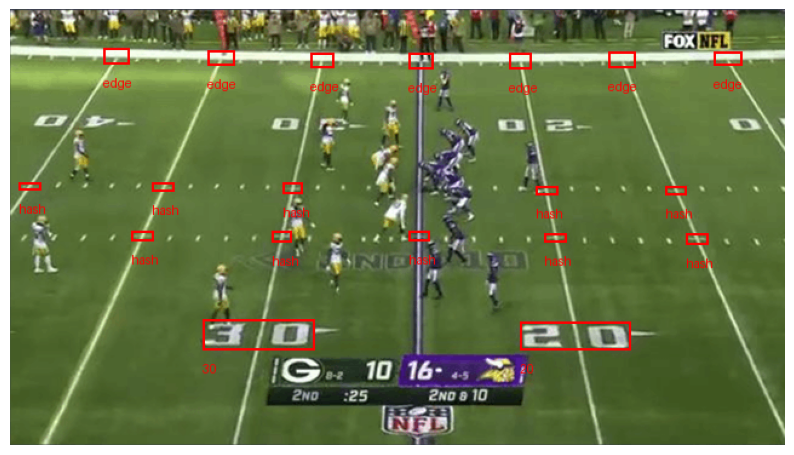

In [101]:
show_lbls(img_og, lbls)

## Line Detection
Possible solutions:

    1. find line with most pts

    2. Successive RANSAC with Linear Regression
    
    3. Hough Lines

### Most pts

In [102]:
def get_all_lines(lbls, tresh):
    lines = []

    for i in range(len(lbls)-1):
        for j in range(i+1, len(lbls)):
            # determine the points to use on the bbox to create a max line and min line between 2 lines

            # if 1x<2x and 1y<2y -> (BL TR) (BL TR)
            # if 1x<2x and 1y>2y -> (BR TL) (BR TL)
            # if 1x>2x and 1y<2y -> (BR TL) (BR TL)
            # if 1x>2x and 1y>2y -> (BL TR) (BL TR)

            b1 = np.array([lbls[i]["x"], lbls[i]["y"]])
            t1 = np.array([lbls[i]["x"], lbls[i]["y"]])
            w1 = lbls[i]["width"]/2
            h1 = lbls[i]["height"]/2
            id1 = lbls[i]["id"]

            b2 = np.array([lbls[j]["x"], lbls[j]["y"]])
            t2 = np.array([lbls[j]["x"], lbls[j]["y"]])
            w2 = lbls[j]["width"]/2
            h2 = lbls[j]["height"]/2
            id2 = lbls[j]["id"]

            slope_middle = (b2-b1)[1]/(b2-b1)[0]
            line = {
                "middle": {
                    "point": b1,
                    "basis": slope_middle
                },
                "points": set([id1, id2]),
                "count": 2
            }

            x_fac = 1 if b1[0] < b2[0] else -1
            y_fac = 1 if b1[0] < b2[0] else -1

            b1[0] -= w1*x_fac*y_fac
            t1[0] += w1*x_fac*y_fac
            b2[0] -= w2*x_fac*y_fac
            t2[0] += w2*x_fac*y_fac
            
            b1[1] += h1
            t1[1] -= h1
            b2[1] += h2
            t2[1] -= h2

            slope_top = (t2-t1)[1]/(t2-t1)[0]
            slope_bottom = (b2-b1)[1]/(b2-b1)[0]

            line["bottom"] = {
                "point": b1,
                "slope": slope_bottom
            }
            line["top"] = {
                "point": t1,
                "slope": slope_top
            }

            for k in range(len(lbls)):
                id = lbls[k]["id"]
                if id != id1 and id != id2:
                    x = lbls[k]["x"]
                    y = lbls[k]["y"]
                    # w = lbls[k]["width"]
                    # h = lbls[]

                    top_pred = slope_top*(x-t1[0])+t1[1]
                    bottom_pred = slope_bottom*(x-b1[0])+b1[1]

                    if y <= bottom_pred + tresh and y >= top_pred - tresh:
                        line["points"].add(id)
                        line["count"] += 1

                        if line["count"] == len(lbls):
                            return [line]

            
            lines.append(line)
            
    return lines

In [103]:
def merge_lines(lines):
    for i in range(len(lines)):
        lines[i]["merged"] = False
        for j in range(len(lines)):
            if i != j:
                if lines[i]["points"] <= lines[j]["points"]:
                    lines[i]["merged"] = True
                    break
    
    return [l for l in lines if not l["merged"]]

In [104]:
def get_best_lines(lbls, tresh):
    best_lines = []
    lines = get_all_lines(lbls, tresh)
    # lines_sorted = {}
    lines_trimmed = [x for x in lines if x["count"] > 2]
    lines = sorted(lines, key=lambda x : x["count"], reverse=True)

    total_lbls = len(lbls["boxes"])
    max_count = lines[0]["count"]

    for line in lines:
        count = line["count"]

        if count >= total_lbls-1:
            return [[line, None]]
        
        
        

    # for line in lines:
    #     count = line["count"]
    #     if lines_sorted[count] is None:
    #         lines_sorted[count] = []
    #     lines_sorted[count].append(line)

    # line_counts = list(lines_sorted.keys()).sort(reverse=True)

    # if line_counts[0] >= total_lbls-1:
    #     return [[lines_sorted[line_counts[0]][0], None]]




In [105]:
hashes = [x for x in lbls["boxes"] if x["label"] == "hash"]
edges = [x for x in lbls["boxes"] if x["label"] == "edge"]
lines = get_all_lines(edges, tresh=0)
# lines = merge_lines(lines)
df = pd.DataFrame(lines)
df[["count", "points"]]

,count,points
0,7,"{4, 9, 12, 13, 14, 15, 16}"


## Hash Line Detection

## Yard Line Detection

## Map Drawing

## Homography